# Inference and Validation

In [1]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [3]:
model = Classifier()
images, labels = next(iter(trainloader))

# Get the class probabilities
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


In [4]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

# print(top_p)

tensor([[0],
        [5],
        [0],
        [5],
        [5],
        [0],
        [0],
        [5],
        [0],
        [8]])


In [5]:
equals = top_class == labels

In [6]:
equals.shape

torch.Size([64, 64])

In [7]:
equals = top_class == labels.view(*top_class.shape)

In [8]:
equals.shape

torch.Size([64, 1])

In [9]:
# equals

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [10]:
# accuaracy = torch.mean(equals)
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 6.25%


In [11]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.514..  Test Loss: 0.435..  Test Accuracy: 0.842
Epoch: 2/10..  Training Loss: 0.394..  Test Loss: 0.396..  Test Accuracy: 0.859
Epoch: 3/10..  Training Loss: 0.358..  Test Loss: 0.397..  Test Accuracy: 0.857
Epoch: 4/10..  Training Loss: 0.333..  Test Loss: 0.414..  Test Accuracy: 0.856
Epoch: 5/10..  Training Loss: 0.319..  Test Loss: 0.431..  Test Accuracy: 0.851
Epoch: 6/10..  Training Loss: 0.303..  Test Loss: 0.384..  Test Accuracy: 0.867
Epoch: 7/10..  Training Loss: 0.291..  Test Loss: 0.390..  Test Accuracy: 0.865
Epoch: 8/10..  Training Loss: 0.283..  Test Loss: 0.370..  Test Accuracy: 0.873
Epoch: 9/10..  Training Loss: 0.274..  Test Loss: 0.371..  Test Accuracy: 0.876
Epoch: 10/10..  Training Loss: 0.268..  Test Loss: 0.386..  Test Accuracy: 0.880


In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 

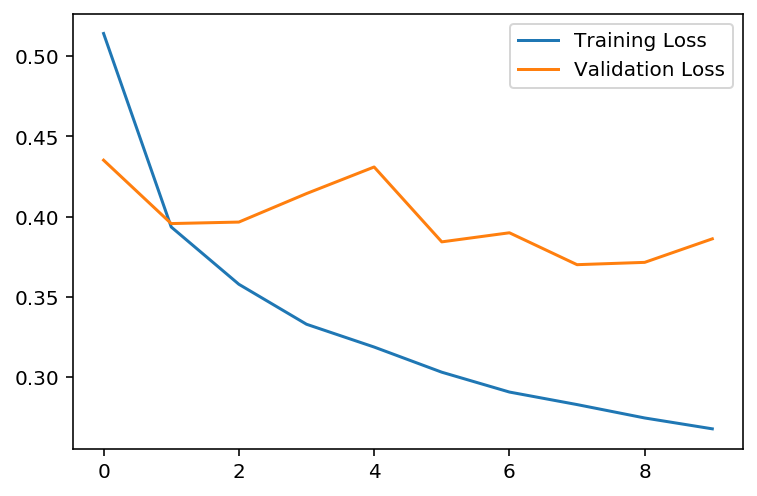

In [13]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend(frameon=True)

# Overfitting

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.02)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
         # output so no dropout here
        x = F.log_softmax(self.output(x), dim=1)
        
        return x
        

In [15]:
## TODO: Define your model with dropout added
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0
train_losses, test_losses = [], []



for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epochs :{}/{}..".format(e+1, epochs), "Training Loss :{:.3f}".format(train_losses[-1]), 
             "Test Loss :{:.3f}".format(test_losses[-1]), "Accuracy :{:.3f}".format(accuracy/len(testloader)))
                

Epochs :1/10.. Training Loss :0.527 Test Loss :0.416 Accuracy :0.849
Epochs :2/10.. Training Loss :0.403 Test Loss :0.416 Accuracy :0.851
Epochs :3/10.. Training Loss :0.367 Test Loss :0.391 Accuracy :0.859
Epochs :4/10.. Training Loss :0.344 Test Loss :0.408 Accuracy :0.859
Epochs :5/10.. Training Loss :0.328 Test Loss :0.383 Accuracy :0.866
Epochs :6/10.. Training Loss :0.320 Test Loss :0.405 Accuracy :0.864
Epochs :7/10.. Training Loss :0.307 Test Loss :0.351 Accuracy :0.876
Epochs :8/10.. Training Loss :0.300 Test Loss :0.385 Accuracy :0.864
Epochs :9/10.. Training Loss :0.294 Test Loss :0.409 Accuracy :0.865
Epochs :10/10.. Training Loss :0.287 Test Loss :0.366 Accuracy :0.874


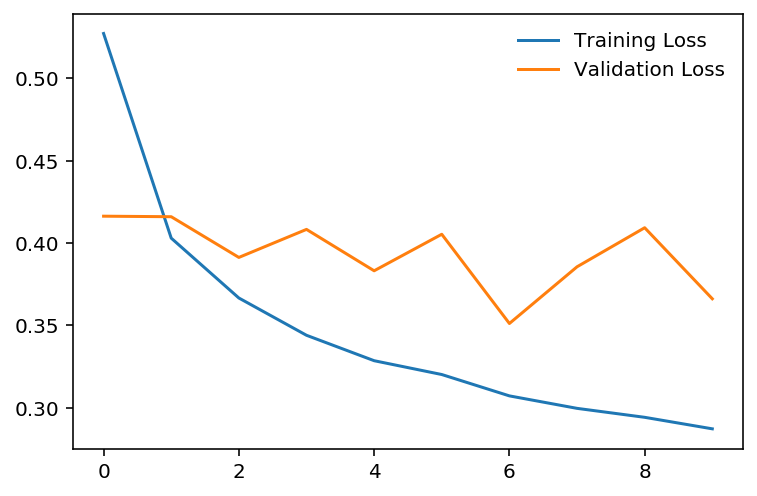

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend(frameon=False)

# Inference

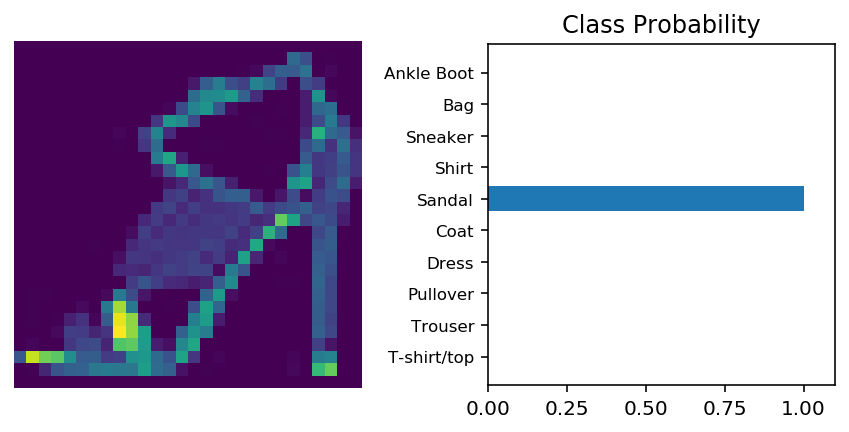

In [36]:
import helper
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.view(1, 784)
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')